In [1]:
import pandas as pd
import sys
sys.path.insert(1, '../PolitiTrend')
import string
import re
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import data_cleaning
from sklearn.model_selection import train_test_split
import numpy as np




from nltk.corpus import stopwords


df = pd.read_csv("/Users/lifeifan/Desktop/ece1786/PolitiTrend/p_and_c.csv")


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lifeifan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lifeifan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
cleaned_data = data_cleaning.remove_stop_words(df,"text","cleaned_text")
cleaned_data = data_cleaning.remove_punctuations(cleaned_data,"cleaned_text","cleaned_text")
cleaned_data = data_cleaning.lemm_text(cleaned_data,"cleaned_text","cleaned_text")

In [3]:
cleaned_data['cmp_code'] = cleaned_data['cmp_code'].replace({'conservatism': 0, 'progressivism': 1})
cleaned_data = cleaned_data.rename(columns={'cmp_code': 'label'})

In [4]:
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2LMHeadModel,
                          GPT2Tokenizer,
                          AdamW, 
                          TextDataset,
                          GPT2Config,
                          DataCollatorForLanguageModeling)

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [6]:
import pandas as pd
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
import torch
# df_reset = df.reset_index(drop=True)
# x_train, x_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.2, shuffle=True)
# x_train = x_train.reset_index(drop=True)
# x_val = x_val.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# y_val = y_val.reset_index(drop=True)






In [7]:

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(cleaned_data, test_size=0.2, random_state=42)

# dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = str(self.dataframe.iloc[idx]['text'])
        label = int(self.dataframe.iloc[idx]['label'])

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# GPT2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

configuration = GPT2Config()
model = GPT2ForSequenceClassification(configuration).from_pretrained("gpt2",num_labels=2)
model.config.pad_token_id = model.config.eos_token_id


train_dataset = CustomDataset(train_df, tokenizer)
val_dataset = CustomDataset(val_df, tokenizer)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [8]:


optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 2

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, 1)
        train_acc += (predicted_labels == labels).sum().item()

        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(train_loader)
    train_acc = train_acc/len(train_df)
    train_loss_list.append(train_loss)  
    train_acc_list.append(train_acc)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, accuracy: {train_acc}')

    # Validation loop
    model.eval()
    val_loss = 0
    val_acc = 0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            _, predicted_labels = torch.max(logits, 1)
            val_acc += (predicted_labels == labels).sum().item()

    val_loss /= len(val_loader)    
    val_loss_list.append(val_loss)            
    val_acc /= len(val_df)                    
    val_acc_list.append(val_acc)  


    print(f'Validation Loss: {val_loss}, Accuracy: {val_acc}')

/Users/lifeifan/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2, Loss: 0.6250542126968504, accuracy: 0.686875
Validation Loss: 0.499515693616122, Accuracy: 0.785
Epoch 2/2, Loss: 0.3722310820734128, accuracy: 0.83375
Validation Loss: 0.45927302110940216, Accuracy: 0.82


In [9]:
model.save_pretrained('/Users/lifeifan/Desktop/ece1786/project/model_parameters/gpt2')

In [10]:

model_path = '/Users/lifeifan/Desktop/ece1786/project/model_parameters/gpt2'
loaded_model = GPT2ForSequenceClassification.from_pretrained(model_path)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')



In [19]:

text = "We will expect students to leave the country at the end of their course, unless they meet new, higher requirements that allow them to work in Britain after their studies have concluded."

inputs = tokenizer(text, return_tensors='pt')

outputs = loaded_model(**inputs)


logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1)


label_mapping = {0: 'conservative', 1: 'progressive'}
predicted_class = label_mapping[predicted_labels.item()]

print(f'Predicted class: {predicted_class}')
print(torch.softmax(logits,dim=1))

Predicted class: conservative
tensor([[0.9955, 0.0045]], grad_fn=<SoftmaxBackward0>)


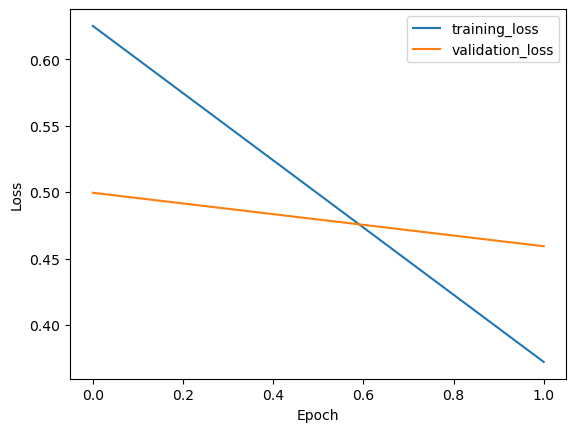

In [11]:
plt.plot(train_loss_list, label='training_loss')
plt.plot(val_loss_list, label='validation_loss')

plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

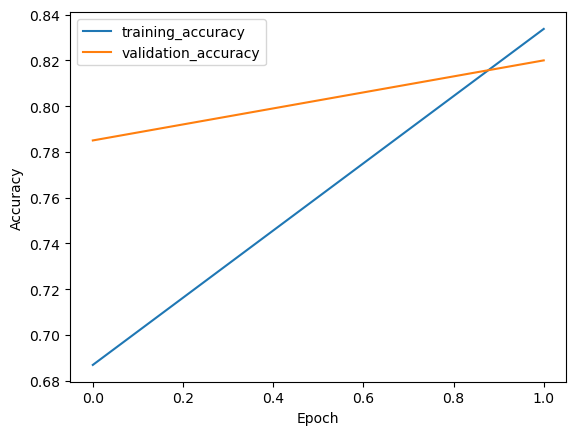

In [12]:
plt.plot(train_acc_list, label='training_accuracy')
plt.plot(val_acc_list, label='validation_accuracy')

plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()